In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Functional, sequential and custom models

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
from IPython.display import Image
tf.__version__

ImportError: cannot import name 'mlutils' from 'local.lib' (unknown location)

## Implementing linear regresion in TF


(150, 1) (150,)


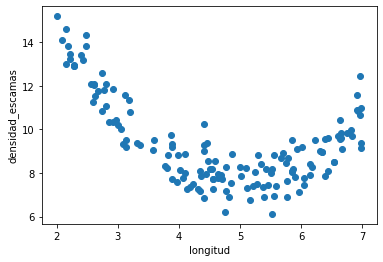

In [2]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)

print(X.shape, y.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
lr.coef_, lr.intercept_

(array([-0.71805906], dtype=float32), 12.689999)

 ## Version 1: raw low level with gradient descent
 
- beware of typing. `tensorflow` is very sensitive to numeric data types (`tf.float32`, `tf.float64`, etc.) Default types in `numpy` and `tensorflow` might not always be the same

In [4]:
from progressbar import progressbar as pbar

epochs = 4000
learning_rate = 0.01

# symbolic variables
w = tf.Variable(np.random.normal(size=(X.shape[-1], 1), scale=.6), dtype=tf.float32)
b = tf.Variable(np.random.normal(size=(1,), scale=.6), dtype=tf.float32)
h = []

#optimization loop
for epoch in pbar(range(epochs)):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y.reshape(-1,1))**2)
        
    gw, gb = t.gradient(loss, [w, b])
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

2022-05-06 14:42:05.321330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.596433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.597123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.601519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

[12.677922] [[-0.7156864]]


(0.0, 50.0)

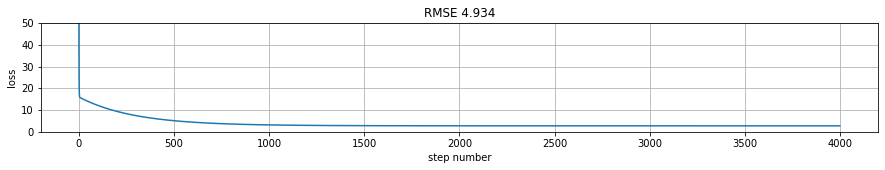

In [5]:
rmse = tf.reduce_mean((tf.matmul(X,w)+b-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 2: using `tf.function` to speed up

In [6]:
epochs = 4000

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1)).astype(np.float32)*.6) 
b.assign(np.random.normal(size=(1,)).astype(np.float32))

@tf.function
def get_gradient(w, b, X, y):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y)**2)
        
    gw, gb = t.gradient(loss, [w, b])
    return gw, gb, loss

#optimization loop
h = []
for epoch in pbar(range(epochs)):
        
    gw, gb, loss = get_gradient(w, b, X, y.reshape(-1,1))
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)

    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]

print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


[12.678748] [[-0.7158488]]


(0.0, 50.0)

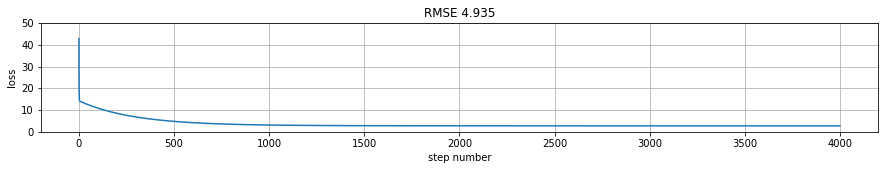

In [7]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 3: using batches with random shuffling (stochastic gradient descent)

notice we tune the number of epochs as the number of weights updates increases

In [8]:
#optimization loop
batch_size = 16
epochs = 400

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1))*.6) 
b.assign(np.random.normal(size=(1,)))

h = []

for epoch in pbar(range(epochs)):
    
    idxs = np.random.permutation(len(X))
    
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
        
        gw, gb, loss = get_gradient(w, b, X_batch, y_batch.reshape(-1,1))

        w.assign_sub(learning_rate * gw)
        b.assign_sub(learning_rate * gb)
        
        h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100% (400 of 400) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


[12.676858] [[-0.68440795]]


(0.0, 50.0)

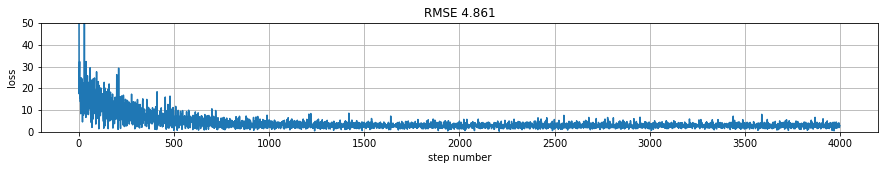

In [9]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 4: packing up with Keras `class` API  and custom SGD

observe:

- the`build` method that is called by Keras whenever `input_shape` is known
- we use `add_weight` so that our model weights are known to the Keras model framework (`trainable_variables`, `get_weights`, etc.) 

see [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [332]:
class LinearRegressionModel4(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
        self.b = self.add_weight(shape=(1,), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = tf.reduce_mean( (self(X)-y)**2)

        gw, gb = t.gradient(loss, [self.w, self.b])
        return gw, gb, loss

    def fit(self, X,y, epochs, batch_size=16, learning_rate=0.01):
        y = y.reshape(-1,1)
        self.h=[]
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]            

                gw, gb, loss = self.get_gradient(X_batch,y_batch)
                self.w.assign_sub(learning_rate * gw)
                self.b.assign_sub(learning_rate * gb)
                self.h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
        self.h = np.r_[self.h]


In [333]:
model = LinearRegressionModel4()

observe that we can use the object directly on data to get predictions

In [334]:
model(X[:2])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.04066426],
       [-0.04316743]], dtype=float32)>

or with the  `.predict` method

In [335]:
model.predict(X[:2])

array([[-0.04066426],
       [-0.04316743]], dtype=float32)

In [336]:
model.trainable_variables

[<tf.Variable 'linear_regression_model4/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.00150557]], dtype=float32)>,
 <tf.Variable 'linear_regression_model4/Variable:0' shape=(1,) dtype=float32, numpy=array([-0.0464113], dtype=float32)>]

In [337]:
model.get_weights()

[array([[0.00150557]], dtype=float32), array([-0.0464113], dtype=float32)]

and fit the model

In [338]:
model.fit(X, y, epochs=400, batch_size=16)

100% (400 of 400) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [339]:
model.b.numpy(), model.w.numpy()

(array([12.6924925], dtype=float32), array([[-0.5818763]], dtype=float32))

(0.0, 50.0)

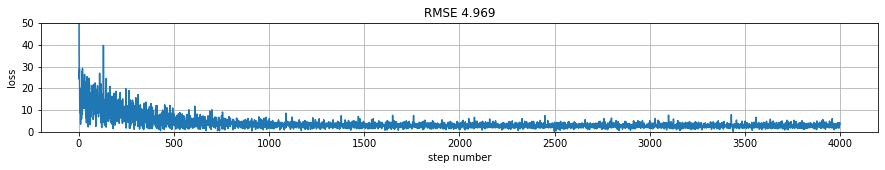

In [340]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(model.h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)